In [ ]:
from model.Fotomics.Fotomics import LogScaler, FftTransformer

import pandas as pd
import csv 
import numpy as np 
from sklearn.model_selection import train_test_split


from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# 5. Fotomics_data_processing

In [92]:
filepath="data/Darmanis.csv"

true_gene_idx = []
with open("Vec2Image_top_genes.txt", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for row in reader:
        true_gene_idx.append(int(row[0]))

true_gene_idx

[18473, 19684, 5862, 3088, 17587, 7832, 2353, 13246, 16680]

In [93]:
def Fotomics_data_processing(filepath, test_size=0.2, random_state=42, fft_pixels=128, plot_fft=False):

    df = pd.read_csv(filepath, header=None)
    gene_column = df.iloc[:, 0]               
    sample_data = df.iloc[:, 1:]              

    clean_sample_data = sample_data.dropna(axis=1)

    df = pd.concat([gene_column, clean_sample_data], axis=1)
    
    mt = df.to_numpy()


    tmp_head = mt[0]
    mt = mt[1:]
    np.random.shuffle(mt)
    mt = np.vstack((tmp_head, mt))

    mt = mt.T
    tmp_head = mt[0]
    mt = mt[1:]
    np.random.shuffle(mt)
    mt = np.vstack((tmp_head, mt))


    mt_Y = mt.T[0][1:]                       # 标签
    mt_Y = mt_Y.astype(str) 
    mt1 = mt[:,1:]
    mt_X = mt1[1:]
    mt_X = mt_X.astype('float64')      # 特征矩阵（去除表头和标签列）

    unique_classes = np.unique(mt_Y)

    x_train, x_test, y_train, y_test = train_test_split(
        mt_X, mt_Y, test_size=test_size, stratify=mt_Y, random_state=random_state)


    ln = LogScaler()
    x_train_norm = ln.fit_transform(x_train)
    x_test_norm = ln.transform(x_test)


    fft = FftTransformer(pixels=fft_pixels)
    fft_fit = fft.fit(x_train_norm, plot=plot_fft)

    return x_train_norm, x_test_norm, y_train, y_test, np.unique(mt_Y), fft_fit, unique_classes

C:\Users\luo\AppData\Local\Temp\ipykernel_382276\3507571462.py:3: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255

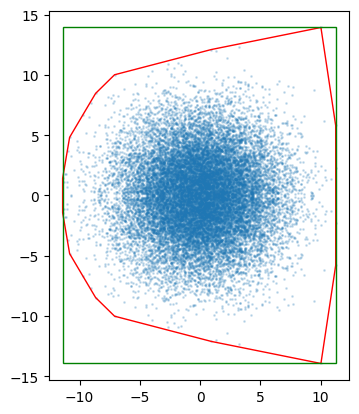

In [94]:
x_train_norm, x_test_norm, y_train, y_test, unique_labels,fft_fit, unique_classes = Fotomics_data_processing(
    filepath=filepath,
    test_size=0.2,
    random_state=42,
    fft_pixels=128,
    plot_fft=True
)

# 6. Basic_Fotomics

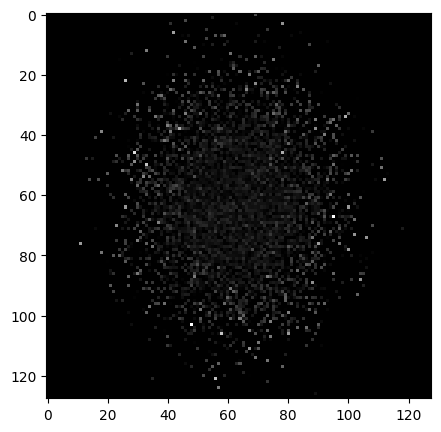

In [95]:
def Basic_Fotomics(fft_fit, x_train_norm,x_test_norm, plot=False):
    x_train_img_Basic = fft_fit.transform(x_train_norm)
    x_test_img_Basic = fft_fit.transform(x_test_norm)

    if plot:
        plt.figure(figsize=(5, 5))
        plt.imshow(x_train_img_Basic[0], cmap='gray')

    return x_train_img_Basic, x_test_img_Basic

x_train_img_Basic, x_test_img_Basic = Basic_Fotomics(
    fft_fit,
    x_train_norm,
    x_test_norm,
    plot=True
)

# 7. RGB_Fotomics

In [96]:
from sklearn.cluster import KMeans
import numpy as np

def cluster_with_custom_centers(fft_fit, center_indices):
    coords = fft_fit.coords()
    coords_df = pd.DataFrame(coords)
    coords_array = coords_df.values
    init_centers = coords_array[center_indices]

    kmeans = KMeans(n_clusters=len(center_indices), init=init_centers, n_init=1, random_state=0)
    kmeans.fit(coords_array)
    
    return kmeans.labels_, kmeans.cluster_centers_



In [97]:
def RGB_transform(colors, Classes, fft_fit, pixels, plot=False):
    coords_df = pd.DataFrame(fft_fit.coords())
    img_coords = pd.DataFrame(np.vstack((
        coords_df.T,
        Classes
    )).T)
    
    # Add three RGB values based on the class value in img_coords
    # Iterate through each row and add RGB values
    RGB_df = pd.DataFrame(np.zeros((img_coords.shape[0], 3)), columns=['R', 'G', 'B'])
    for i in range(len(img_coords)):
        # Get the class value of the current row
        class_value = img_coords.iloc[i, -1]
        
        # Get the corresponding color based on the class value
        color = colors[int(class_value)]
        # Add the color values to RGB_df
        RGB_df.iloc[i] = color

    # Concatenate RGB_df with img_coords
    img_coords = pd.concat([img_coords, RGB_df], axis=1)
    img_coords.columns = ['X', 'Y', 'Class', 'R', 'G', 'B']

    img_coords_new = img_coords.copy()
    img_coords_new = img_coords_new.drop(columns=['Class'])

    # Group by X and Y, and take the average for identical values
    img_coords_new = img_coords_new.groupby(['X', 'Y']).mean().reset_index()

    # Initialize a blank RGB image
    img = np.zeros((pixels, pixels, 3), dtype=np.float32)
    # Iterate through img_coords_new and fill in the RGB values in the image
    for i in range(len(img_coords_new)):
        x = int(img_coords_new.iloc[i, 0])
        y = int(img_coords_new.iloc[i, 1])
        r = img_coords_new.iloc[i, 2]
        g = img_coords_new.iloc[i, 3]
        b = img_coords_new.iloc[i, 4]
        
        # Fill in the RGB values
        img[x, y] = [r, g, b]

    if plot == True:
        plt.imshow(img)
        plt.axis('off')
        plt.show()

    return img

In [98]:
def RGB_Fotomics(fft_fit, true_gene_idx, x_train_img_Basic, x_test_img_Basic, pixels=128, plot=True):

    labels, centers = cluster_with_custom_centers(fft_fit, true_gene_idx)

    classes = pd.DataFrame(labels).T
    RGB_classes = np.unique(classes)
    n_classes = len(RGB_classes)

    colors = sns.color_palette("hsv", n_classes)

    RGB_image = RGB_transform(colors, classes, fft_fit, pixels, plot=plot)

    x_train_img_RGB = x_train_img_Basic * RGB_image[None, :, :, :]
    x_test_img_RGB = x_test_img_Basic * RGB_image[None, :, :, :]
    
    return x_train_img_RGB, x_test_img_RGB


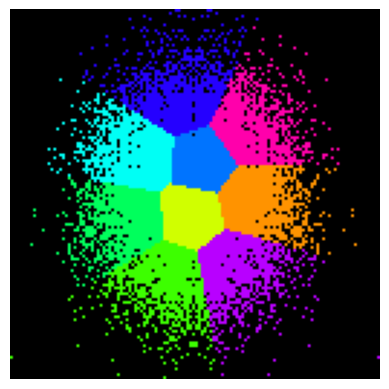

In [99]:
x_train_img_RGB, x_test_img_RGB = RGB_Fotomics(
    fft_fit,
    true_gene_idx,
    x_train_img_Basic,
    x_test_img_Basic,
    pixels=128,
    plot=True
)

# 8. CNN_train

In [100]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras import layers
import numpy as np

In [101]:
label = unique_classes.tolist()

n_lst=[]
for i in range(len(y_train)):
  for j in range(len(label)):
    if y_train[i] == label[j]:

      n_lst.append(j)

y_new_train = np.array(n_lst,dtype='float64')

n_lst=[]
for i in range(len(y_test)):
  for j in range(len(label)):
    if y_test[i] == label[j]:
      n_lst.append(j)

y_new_test = np.array(n_lst,dtype='float64')

df_y_train = to_categorical(y_new_train,num_classes=len(label))

In [102]:
print(x_train_img_RGB.shape)
print(df_y_train.shape)

(372, 128, 128, 3)
(372, 9)


In [103]:
from keras.callbacks import EarlyStopping, ModelCheckpoint , ReduceLROnPlateau


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

def CNN_train(x_train, y_train, input_shape=(128, 128, 3), num_classes=None,
                          batch_size=32, epochs=90, validation_split=0.2):

    if num_classes is None:
        num_classes = y_train.shape[1]

    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Dense(num_classes))
    model.add(Activation('sigmoid'))  

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8,
                                  verbose=1, min_delta=1e-4, mode='auto')

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_split=validation_split,
              callbacks=[early_stopping, reduce_lr])

    return model

# 训练模型




In [104]:
Basic_Fotomics_model = CNN_train(
    x_train_img_Basic,
    df_y_train,
    input_shape=(128, 128, 3),
    num_classes=len(unique_classes),
    batch_size=32,
    epochs=90,
    validation_split=0.2
)


Epoch 1/90


d:\EnvOfCode\anaconda3\envs\CXXA1\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - categorical_accuracy: 0.2111 - loss: 2.3833 - val_categorical_accuracy: 0.2533 - val_loss: 2.0442 - learning_rate: 0.0010
Epoch 2/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - categorical_accuracy: 0.4717 - loss: 1.9221 - val_categorical_accuracy: 0.4667 - val_loss: 1.6923 - learning_rate: 0.0010
Epoch 3/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - categorical_accuracy: 0.5322 - loss: 1.6086 - val_categorical_accuracy: 0.5867 - val_loss: 1.3975 - learning_rate: 0.0010
Epoch 4/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - categorical_accuracy: 0.7196 - loss: 0.9785 - val_categorical_accuracy: 0.6533 - val_loss: 0.9976 - learning_rate: 0.0010
Epoch 5/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - categorical_accuracy: 0.9132 - loss: 0.3268 - val_categorical_accuracy: 0.7733 - val_loss: 0.7672 - learning_rate: 0.0010
Epoch 6/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - categorical_accuracy: 0.9917 - loss: 0.0790 - val_categorical_accuracy: 0.7467 - va

In [105]:
RGB_Fotomics_model = CNN_train(
    x_train_img_RGB,
    df_y_train,
    input_shape=(128, 128, 3),
    num_classes=len(unique_classes),
    batch_size=32,
    epochs=90,
    validation_split=0.2
)

Epoch 1/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - categorical_accuracy: 0.2171 - loss: 2.1249 - val_categorical_accuracy: 0.4400 - val_loss: 1.7530 - learning_rate: 0.0010
Epoch 2/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - categorical_accuracy: 0.5108 - loss: 1.7015 - val_categorical_accuracy: 0.5333 - val_loss: 1.4512 - learning_rate: 0.0010
Epoch 3/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - categorical_accuracy: 0.7684 - loss: 0.9928 - val_categorical_accuracy: 0.7067 - val_loss: 1.0429 - learning_rate: 0.0010
Epoch 4/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - categorical_accuracy: 0.9608 - loss: 0.3330 - val_categorical_accuracy: 0.6400 - val_loss: 1.0106 - learning_rate: 0.0010
Epoch 5/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - categorical_accuracy: 0.9792 - loss: 0.0993 - val_categorical_accuracy: 0.7867 - val_loss: 0.8733 - learning_rate: 0.0010
Epoch 6/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - categorical_accuracy: 0.9929 - loss: 0.0509 - val_categorical_accuracy: 

# 9. CNN_test

In [106]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def CNN_test(model, x_test, y_true, method='basic'):
    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    results = {
        'accuracy': round(accuracy_score(y_true, y_pred), 4),
        'f1_micro': round(f1_score(y_true, y_pred, average='micro'), 4),
        'f1_macro': round(f1_score(y_true, y_pred, average='macro'), 4),
        'f1_weighted': round(f1_score(y_true, y_pred, average='weighted'), 4)
    }

    print(f"Evaluation Results of {method}:")
    for metric, score in results.items():
        print(f"{metric.capitalize().replace('_', ' ')}: {score}")

    return results


In [107]:
Basic_Fotomics_results = CNN_test(
    Basic_Fotomics_model,
    x_test_img_Basic,
    y_new_test,
    method='Basic Fotomics'
)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Evaluation Results of Basic Fotomics:
Accuracy: 0.7766
F1 micro: 0.7766
F1 macro: 0.697
F1 weighted: 0.7661


In [108]:
RGB_Fotomics_results = CNN_test(
    RGB_Fotomics_model,
    x_test_img_RGB,
    y_new_test,
    method='RGB Fotomics'
)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Evaluation Results of RGB Fotomics:
Accuracy: 0.7872
F1 micro: 0.7872
F1 macro: 0.7049
F1 weighted: 0.7626
